# Pretrain Model

Summary/Record:
- Finetune, using SGD seems better than Adam.
- Resnet101 is better than Resnet18, faster loss decay.

ToDo:
- Deconv inputs to size=224x224 for resnet may obtain a better result?
- Learning rate decay.

In general both transfer learning methods follow the same few steps:

- Initialize the pretrained model
- Reshape the final layer(s) to have the same number of outputs as the number of classes in the new dataset
- Define for the optimization algorithm which parameters we want to update during training
- Run the training step

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  0.4.1
Torchvision Version:  0.2.1


In [3]:
# Detect if we have a GPU available
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
print(device)

cuda:5


## Input

### Dataset

In [4]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "/data1/lipf/"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 100

# Batch size for training (change depending on how much memory you have)
batch_size = 512

# Number of epochs to train for
num_epochs = 10


### Model Training and Validation Code

Training and validation. 

Input : a PyTorch model, a dictionary of dataloaders, a loss function, an optimizer, a specified number of epochs to train and validate for, and a boolean flag for when the model is an Inception model. 

The is_inception flag is used to accomodate the Inception v3 model. 

The function trains for the specified number of epochs and **after each epoch runs a full validation step**. It also keeps track of the best performing model (in terms of validation accuracy), and at the end of training returns the best performing model.

In [5]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

#     best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            iters = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                iters += inputs.size(0)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    # torch.max(a,1) 返回每一行中最大值的那个元素，且返回其索引，１表示行
                    _, preds = torch.max(outputs, 1)
                    # _, preds = torch.topk(outputs, 5)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                # 通过.item() 从0维张量中获得 python number.
                # 如果loss不转为　python number　再累加，内存消耗会一直在增加。因为0维张量会增加梯度的计算历史
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                # 转置，然后扩展
                # running_corrects += torch.sum(preds == labels.data.view(1,-1).t().expand_as(preds))
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history




### Set Model Parameters’ .requires_grad attribute

This helper function sets the .requires_grad attribute of the parameters in the model to False when we are feature extracting. By default, when we load a pretrained model all of the parameters have .requires_grad=True, which is fine if we are training from scratch or finetuning. 

However, if we are feature extracting and only want to compute gradients for the newly initialized layer then we want all of the other parameters to not require gradients.

In [6]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

## INITIALIZE AND RESHAPE THE NETWORKS

When feature extracting, we only want to update the parameters of the last layer, or in other words, we only want to update the parameters for the layer(s) we are reshaping. Therefore, we do not need to compute the gradients of the parameters that we are not changing, so for efficiency we set the .requires_grad attribute to False. This is important because by default, this attribute is set to True. Then, when we initialize the new layer and by default the new parameters have .requires_grad=True so only the new layer’s parameters will be updated. When we are finetuning we can leave all of the .required_grad’s set to the default of True.

In [7]:
def initialize_model(model_name, num_classes, use_pretrained=True, is_feature_extracting=False):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet101
        """
        model = models.resnet101(pretrained=use_pretrained)
        set_parameter_requires_grad(model, is_feature_extracting)
        num_ftrs = model.fc.in_features
        model.avgpool = nn.AvgPool2d(kernel_size=1, stride=1, padding=0)
        model.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 32    

    else:
        print("Invalid model name, exiting...")
        exit()

    return model, input_size

In [8]:
# Initialize the model for this run
model_t, input_size = initialize_model(model_name, num_classes, use_pretrained=True, is_feature_extracting=False)
# Send the model to GPU
model_t = model_t.to(device)

## LOAD DATA

In [9]:
def dataLoader(is_train='train', cuda=True, batch_size=512, shuffle=True):
        if is_train == 'train':
            trans = [transforms.RandomHorizontalFlip(),
                     transforms.RandomCrop(32, padding=4),
                     transforms.ToTensor(),
                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
            trans = transforms.Compose(trans)
            data_set = datasets.CIFAR100(root=data_dir, train=True, transform=trans)
        else:
            trans = [transforms.ToTensor(),
                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
            trans = transforms.Compose(trans)
            data_set = datasets.CIFAR100(data_dir, train=False, transform=trans)

        return data_set

dataset = {}
for phase in ['train', 'val']:
    dataset[phase] = dataLoader(phase)

dataloaders_dict = {x: torch.utils.data.DataLoader(dataset[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}


## CREATE THE OPTIMIZER

In [10]:
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
def param2update(model, is_feature_extract=False):
    params_to_update = model.parameters()
    print("Params to learn:")
    if is_feature_extract:
        params_to_update = []
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                print("\t",name)
    return params_to_update

In [11]:
params_to_update = param2update(model_t)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight

## RUN TRAINING AND VALIDATION STEP

In [12]:
# Observe that all parameters are being optimized
optimizer_t = optim.Adam(params_to_update, lr=0.001, betas=(0.9, 0.999))

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

In [13]:
# Train and evaluate
model_t, hist = train_model(model_t, dataloaders_dict, criterion, optimizer_t, num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 2.8449 Acc: 0.2878
val Loss: 2.2750 Acc: 0.4071

Epoch 1/9
----------
train Loss: 1.9888 Acc: 0.4586
val Loss: 1.8579 Acc: 0.5018

Epoch 2/9
----------
train Loss: 1.7142 Acc: 0.5231
val Loss: 1.9575 Acc: 0.5014

Epoch 3/9
----------
train Loss: 1.6056 Acc: 0.5479
val Loss: 1.9720 Acc: 0.4906

Epoch 4/9
----------
train Loss: 1.4738 Acc: 0.5818
val Loss: 2.0003 Acc: 0.5274

Epoch 5/9
----------
train Loss: 1.4511 Acc: 0.5897
val Loss: 13.2432 Acc: 0.4528

Epoch 6/9
----------
train Loss: 1.5159 Acc: 0.5816
val Loss: 1.7009 Acc: 0.5472

Epoch 7/9
----------
train Loss: 1.6855 Acc: 0.5457
val Loss: 4.7685 Acc: 0.1436

Epoch 8/9
----------
train Loss: 1.9454 Acc: 0.4738
val Loss: 1.7634 Acc: 0.5249

Epoch 9/9
----------
train Loss: 1.4522 Acc: 0.5870
val Loss: 3.8643 Acc: 0.5060

Training complete in 4m 55s
Best val Acc: 0.547200


## Finetune model - Fix backbone

In [14]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, use_pretrained=True, is_feature_extracting=True)
model_ft.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [15]:
params_to_update_ft = param2update(model_ft, is_feature_extract=True)

Params to learn:
	 fc.weight
	 fc.bias


In [16]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update_ft, lr=0.001, momentum=0.9)

model_ft, hist_ft = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 4.5639 Acc: 0.0303
val Loss: 4.4881 Acc: 0.0600

Epoch 1/9
----------
train Loss: 4.3063 Acc: 0.0878
val Loss: 4.2986 Acc: 0.1022

Epoch 2/9
----------
train Loss: 4.1195 Acc: 0.1300
val Loss: 4.1395 Acc: 0.1285

Epoch 3/9
----------
train Loss: 3.9801 Acc: 0.1520
val Loss: 4.0559 Acc: 0.1495

Epoch 4/9
----------
train Loss: 3.8674 Acc: 0.1734
val Loss: 4.0299 Acc: 0.1584

Epoch 5/9
----------
train Loss: 3.7762 Acc: 0.1852
val Loss: 3.9252 Acc: 0.1706

Epoch 6/9
----------
train Loss: 3.6987 Acc: 0.1945
val Loss: 3.8413 Acc: 0.1758

Epoch 7/9
----------
train Loss: 3.6408 Acc: 0.2016
val Loss: 3.7986 Acc: 0.1810

Epoch 8/9
----------
train Loss: 3.5886 Acc: 0.2062
val Loss: 3.8332 Acc: 0.1834

Epoch 9/9
----------
train Loss: 3.5331 Acc: 0.2123
val Loss: 3.7316 Acc: 0.1896

Training complete in 1m 50s
Best val Acc: 0.189600


## Finetune model - relearn

backbone层参数只需微调，故学习率可以小一些。

classifier层参数为重新学习，学习率大。

In [17]:
class ResNet(nn.Module):
    def __init__(self, num_class):
        super(ResNet, self).__init__()
        net = models.resnet101(pretrained=True)
        self.backbone = nn.Sequential(
            net.conv1,
            net.bn1,
            net.relu,
            net.maxpool,
            net.layer1,
            net.layer2,
            net.layer3,
            net.layer4,
            nn.AvgPool2d(kernel_size=1, stride=1, padding=0),
        )
        num_ftrs = net.fc.in_features
        self.classifier = nn.Sequential(
            nn.Linear(num_ftrs, num_classes)
        )
    
    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
    def get_config_optim(self, lr, lrp):
        return [{ 'params': self.backbone.parameters(), 'lr': lr*lrp},
                {'params': self.classifier.parameters()}]

如果学习率设置不合理会报错：

    OSError: [Errno 9] Bad file descriptor
    
原因？

In [19]:
model_ftr = ResNet(num_classes)
model_ftr.to(device)

lr = 0.05
# optimizer_ft = optim.Adam(model_ft.get_config_optim(lr, 0.1), lr=lr, betas=(0.9, 0.999))
optimizer_ftr = optim.SGD(model_ftr.get_config_optim(lr, 0.1), lr=lr, momentum=0.9)
criterion = nn.CrossEntropyLoss()

model_ftr, hist_ftr = train_model(model_ftr, dataloaders_dict, criterion, optimizer_ftr, num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 3.0201 Acc: 0.2692
val Loss: 2.1843 Acc: 0.4256

Epoch 1/9
----------
train Loss: 1.9208 Acc: 0.4733
val Loss: 1.8232 Acc: 0.5041

Epoch 2/9
----------
train Loss: 1.5994 Acc: 0.5508
val Loss: 1.7521 Acc: 0.5335

Epoch 3/9
----------
train Loss: 1.3737 Acc: 0.6054
val Loss: 1.6099 Acc: 0.5557

Epoch 4/9
----------
train Loss: 1.2102 Acc: 0.6466
val Loss: 1.6261 Acc: 0.5616

Epoch 5/9
----------
train Loss: 1.0643 Acc: 0.6855
val Loss: 1.5898 Acc: 0.5759

Epoch 6/9
----------
train Loss: 0.9387 Acc: 0.7196
val Loss: 1.6225 Acc: 0.5767

Epoch 7/9
----------
train Loss: 0.8457 Acc: 0.7415
val Loss: 1.6252 Acc: 0.5870

Epoch 8/9
----------
train Loss: 0.7337 Acc: 0.7751
val Loss: 1.6437 Acc: 0.5869

Epoch 9/9
----------
train Loss: 0.6531 Acc: 0.7982
val Loss: 1.7431 Acc: 0.5860

Training complete in 4m 44s
Best val Acc: 0.587000


### Seems overfit.

In [ ]:
# 以下代码功能等同于上面两个步骤

# model_ftr = models.resnet101(pretrained=True)
# num_ftrs = model_ftr.fc.in_features
# model_ftr.avgpool = nn.AvgPool2d(kernel_size=1, stride=1, padding=0)
# model_ftr.fc = nn.Linear(num_ftrs, num_classes)
# model_ftr.to(device)

# ignored_params = list(map(id, model_ftr.fc.parameters()))
# base_params = filter(lambda p:id(p) not in ignored_params, model_ftr.parameters())

# params_list = [{'params':base_params, 'lr':0.001}]
# params_list.append({'params':model_ftr.fc.parameters(), 'lr':0.01})

# optimizer_ftr = optim.SGD(params_list, lr=0.001, momentum=0.9)

# model_ftr, hist_ftr = train_model(model_ftr, dataloaders_dict, criterion, optimizer_ftr, num_epochs=num_epochs)

## Plot accuracy

In [20]:
def plotacc(hist, hist_ft, hist_ftr, num_epochs):
    t_hist = []
    ft_hist = []
    ftr_hist = []
    
    t_hist = [h.cpu().numpy() for h in hist]
    ft_hist = [h.cpu().numpy() for h in hist_ft]
    ftr_hist = [h.cpu().numpy() for h in hist_ftr]

    plt.title("Validation Accuracy")
    plt.xlabel("Training Epochs")
    plt.ylabel("Validation Accuracy")
    plt.plot(range(1,num_epochs+1),t_hist,label="Relearn")
    plt.plot(range(1,num_epochs+1),ft_hist,label="Finetune-fix-backbone")
    plt.plot(range(1,num_epochs+1),ftr_hist,label="Finetune-relearn")
    plt.ylim((0,1.))
    plt.xticks(np.arange(1, num_epochs+1, 2.0))
    plt.legend()
    plt.show()

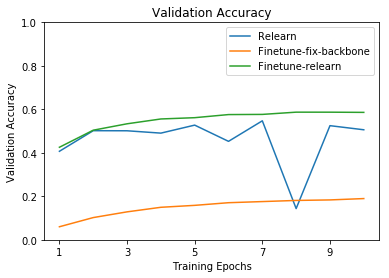

In [21]:
plotacc(hist, hist_ft, hist_ftr, num_epochs)

## Save model

In [22]:
# save parameters
def save_model(save_path):
    torch.save(model_ftr.cpu().state_dict(), save_path)
    
save_path = './model_ftr_587.pth'
save_model(save_path)